<a href="https://colab.research.google.com/github/YanzhaoZ/PreBit/blob/main/price_model_with_Pcent_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd


     |████████████████████████████████| 5.5MB 10.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=ebe676869ba1bb44ca6ba08264ef14a55b0d1736acba485e94a407ab53fa7543
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


# Loading the Price Data

In [3]:
start_date ='2015-01-01'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

#relative_price, will calculate the change in % compared to the day before. 
relative_price = (price/price.shift(1)-1)

[*********************100%***********************]  1 of 1 completed


In [4]:
relative_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.019835,-0.014343,-0.001395,0.002492,0.002492,-0.021888
2015-01-03,0.002442,-0.002181,-0.103593,-0.107767,-0.107767,3.205047
2015-01-04,-0.107036,-0.088593,-0.083499,-0.060079,-0.060079,0.682956
2015-01-05,-0.057130,-0.030947,0.029005,0.038907,0.038907,-0.209716


In [5]:
#add in the label
#I can start with the % change of the daily closing price, then create labels.
#another way could be to look at the next day High vs today Close.  

#setting price change threshold
Threshold = 0

price_2= price.Close.to_frame()
price['change']=price_2.apply(lambda x: x.shift(-1)/x -1)
price['change_label']=price['change'].apply (lambda x: x> Treshold )
#NaN > 0 gives false? Perhaps I could drop na before this step? 


#copy the label to relative_price part as well. 
relative_price['change'] = price['change']
relative_price['change_label']=price['change_label']

In [6]:
print (len(price),len(relative_price))

1826 1826


In [7]:
price = price.dropna()
relative_price = relative_price.dropna()

In [8]:
#price would lose the last day, because no information on next day price to create the label
#relative price, would ALSO lose the first day, because no information to calculate the relative changes .
print (len(price),len(relative_price))

1825 1824


In [9]:
relative_price['change_label'].value_counts()

True     1000
False     824
Name: change_label, dtype: int64

# Adding in technical indicators

In [10]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [ ]:
price_processed = get_technical_indicators(price)
#price.head()

In [ ]:
price_processed.tail()

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2019-12-25,7325.755859,7357.020020,7220.991211,7275.155762,7275.155762,21559505148,-0.004974,False,7296.817801,7272.840518,7368.426134,7267.012086,-101.414048,216.709771,7706.260059,6839.420977,7296.493060
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,0.007062,True,7301.978167,7262.871908,7358.836553,7262.697426,-96.139127,206.236480,7675.344867,6850.398948,7258.142218
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360995,0.003827,True,7312.159877,7250.638184,7353.744096,7266.911419,-86.832677,193.541738,7637.721659,6863.554708,7279.439659
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,0.014302,True,7330.278669,7239.293062,7351.095662,7274.769698,-76.325964,178.778125,7596.849312,6881.736812,7305.140042
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257701,-0.017468,False,7317.573521,7232.545805,7356.396193,7297.520949,-58.875243,179.979293,7592.504391,6872.587219,7383.481902


In [ ]:
price_processed = price_processed.dropna()
price_processed.isnull().value_counts()

Open   High   Low    Close  Adj Close  Volume  change  change_label  ma7    ma21   26ema  12ema  MACD   20sd   upper_band  lower_band  ema  
False  False  False  False  False      False   False   False         False  False  False  False  False  False  False       False       False    1784
dtype: int64

In [ ]:
price_processed.head()
#although I'm not very sure about how 26ema can be calculated when I don't have 26 days of data before this day ? 
#and ema, with this particular set up, seems a bit off? : https://stackoverflow.com/questions/37924377/does-pandas-calculate-ewm-wrong
#the link above provides an alternate view, but I think with the amount of days I have, it shouldn't really matter that much. 
#Let's keep going w/o it first. 

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,-0.002975,False,222.477857,232.991715,229.198966,225.709504,-3.489462,15.323515,263.638745,202.344686,220.382635
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,0.011766,True,221.382429,232.624477,228.289994,224.679632,-3.610362,15.644742,263.913961,201.334992,219.584210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,0.061611,True,222.047145,232.070096,227.707355,224.221244,-3.486111,15.830085,263.730267,200.409925,221.037408
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,0.092997,True,223.927288,232.191430,228.386241,225.977068,-2.409173,15.415100,263.021630,201.361229,230.630471
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,-0.087424,False,228.151147,232.642573,230.896032,230.874410,-0.021622,15.707818,264.058209,201.226937,248.424167


In [ ]:
#visualise the chart
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

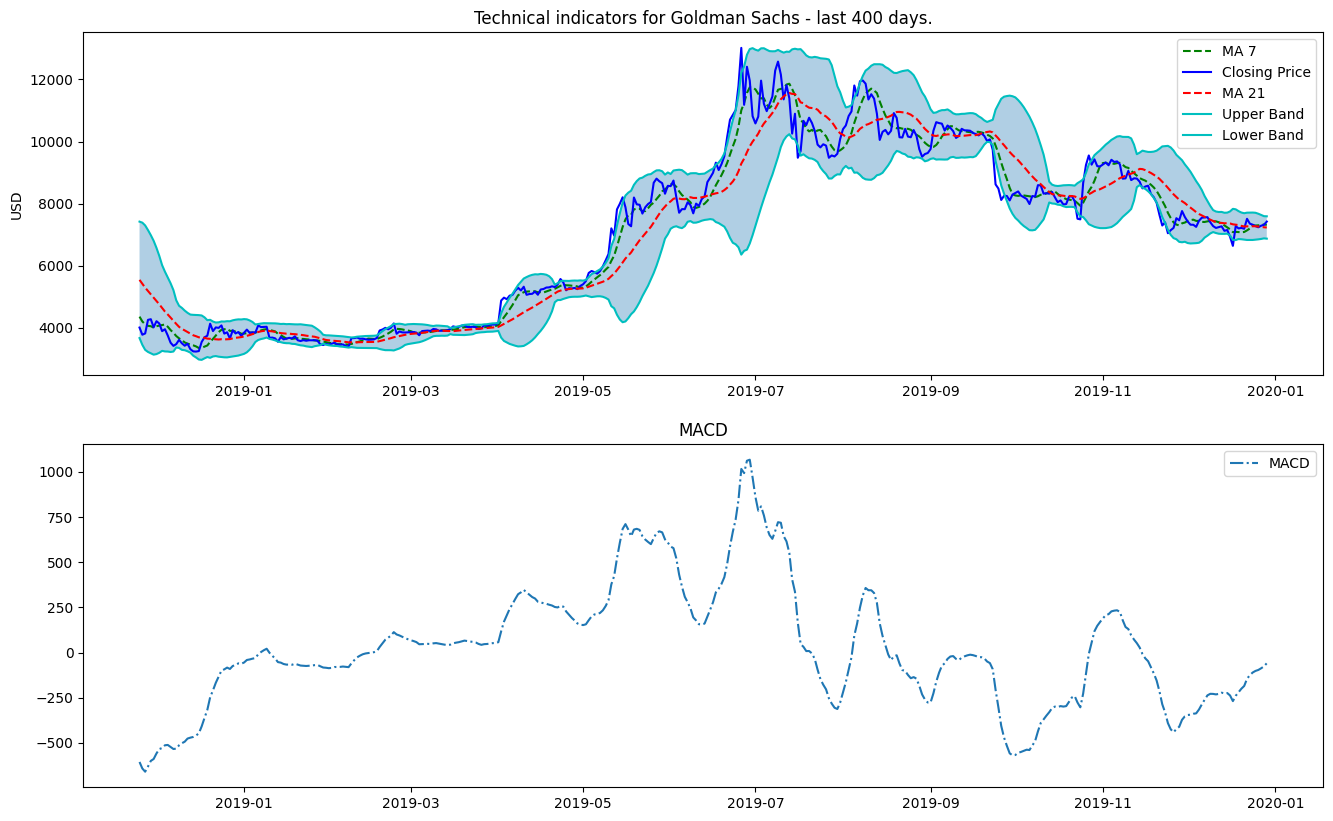

In [ ]:
plot_technical_indicators(price_processed, 400)

In [ ]:
price_processed.head()

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,-0.002975,False,222.477857,232.991715,229.198966,225.709504,-3.489462,15.323515,263.638745,202.344686,220.382635
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,0.011766,True,221.382429,232.624477,228.289994,224.679632,-3.610362,15.644742,263.913961,201.334992,219.584210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,0.061611,True,222.047145,232.070096,227.707355,224.221244,-3.486111,15.830085,263.730267,200.409925,221.037408
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,0.092997,True,223.927288,232.191430,228.386241,225.977068,-2.409173,15.415100,263.021630,201.361229,230.630471
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,-0.087424,False,228.151147,232.642573,230.896032,230.874410,-0.021622,15.707818,264.058209,201.226937,248.424167


# Format data for model

In [12]:
#now perhaps convert them to a list, and then tensor, to proceed to process the price data? 

x_input=relative_price.drop(['change','change_label'],axis=1).values

# scaler = MinMaxScaler()
# x_input= scaler.fit_transform(x_input)
x_input=x_input.tolist()

x_label=relative_price['change_label'].values
x_label=x_label.reshape(-1,).tolist()
#try to encode label 
x_label = [1 if x else 0 for x in x_label]


In [13]:
x_input[0]

[-0.019835497362194032,
 -0.01434302849500968,
 -0.0013948538523216314,
 0.0024917184690256278,
 0.0024917184690256278,
 -0.021887501477624083]

In [ ]:
#roe relative price 
# x_input = relative_price.drop(['change','change_label'],axis = 1).values


# # x_input= min_max_scaler.fit_transform(x_input)
# x_input=x_input.tolist()

# x_label=relative_price['change_label'].values
# x_label=x_label.reshape(-1,).tolist()
# #try to encode label 
# x_label = [1 if x else 0 for x in x_label]

In [14]:
x_input[0],x_label[0]

([-0.019835497362194032,
  -0.01434302849500968,
  -0.0013948538523216314,
  0.0024917184690256278,
  0.0024917184690256278,
  -0.021887501477624083],
 0)

In [15]:
def process(data, window_size):
    output = []
    for i in range(window_size-1, len(data)):
        raw_data = data[i-window_size+1:i+1]
        output.append(raw_data)
    return output

window_size = 10
x_processed = process(x_input, 10)
split = round(len(x_processed)*0.7)
x_train = x_processed[:split]
x_eval = x_processed[split:]
x_train = torch.tensor(x_train, dtype=torch.float)
x_lab = torch.tensor(x_label[window_size-1:window_size-1+split],dtype=torch.float)


x_eval = torch.tensor(x_eval, dtype=torch.float)
x_lab_eval = torch.tensor(x_label[window_size-1+split:],dtype=torch.float)

print(x_train.size())
print(x_lab.size())
print(x_train[0])
print(x_label[0])
print(x_train.type())
print(x_lab.type())
print(x_eval.size())
print(x_lab_eval.size())

torch.Size([1270, 10, 6])
torch.Size([1270])
tensor([[-1.9835e-02, -1.4343e-02, -1.3949e-03,  2.4917e-03,  2.4917e-03,
         -2.1888e-02],
        [ 2.4421e-03, -2.1815e-03, -1.0359e-01, -1.0777e-01, -1.0777e-01,
          3.2050e+00],
        [-1.0704e-01, -8.8593e-02, -8.3499e-02, -6.0079e-02, -6.0079e-02,
          6.8296e-01],
        [-5.7130e-02, -3.0947e-02,  2.9005e-02,  3.8907e-02,  3.8907e-02,
         -2.0972e-01],
        [ 3.5939e-02,  3.3096e-02,  2.8715e-02,  4.2682e-02,  4.2682e-02,
         -4.7124e-01],
        [ 4.1754e-02,  3.8953e-02,  3.8075e-02,  2.8471e-02,  2.8471e-02,
          6.9738e-02],
        [ 2.8167e-02, -1.5461e-02, -3.1935e-03, -3.7331e-02, -3.7331e-02,
         -1.9642e-01],
        [-3.9954e-02, -1.0271e-02, -5.8191e-03,  2.4913e-02,  2.4913e-02,
         -6.3250e-02],
        [ 1.7423e-02, -1.0261e-02, -2.3409e-02, -5.3759e-02, -5.3759e-02,
         -1.8454e-01],
        [-4.4187e-02, -2.9463e-02, -3.2584e-02, -3.3246e-02, -3.3246e-02,
        

# Prepare the Model

In [16]:
train_data = x_train
train_label = x_lab

eval_data = x_eval
#print(test_data.size())
eval_label = x_lab_eval
#print(test_label)

# batching  data
batch_size = 64
train_data = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_data, batch_size)
train_batches = [batch for batch in train_loader]

eval_data = TensorDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_data, batch_size) 
eval_batches = [batch for batch in eval_loader]

In [17]:
class OurModel(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        return percent_change


        

In [18]:
#define model,

model = OurModel(6, 512, 2)

# for i in range(30):
#     for step, batch in enumerate(train_batches):
#         optimizer.step()
#         model.zero_grad()
        
#         data, label = tuple(t for t in batch)
#         model.train()
#         loss = model(data, label)
#         loss.backward()

#     model.eval()
#     output = evaluation(test_loader, model)
#     print('prediction:', output)
#     print(loss)

In [19]:
#define optimizer, loss function
params = model.parameters()
optimizer = optim.Adam(params)
criterion = nn.BCEWithLogitsLoss()

In [20]:
#Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print (device)

cuda


In [21]:
#check number of parameters. 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,166,721 trainable parameters


In [22]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [23]:
#here, let's try to define a function to get the confusion matrix stats



In [24]:
def train(model, train_batches, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for step, batch in enumerate(train_batches):
        
        optimizer.zero_grad()
        
        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)

        loss = criterion(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [25]:
def evaluate(model, eval_batches, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [26]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_batches, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 54.62%
	 Val. Loss: 0.695 |  Val. Acc: 51.07%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 56.26%
	 Val. Loss: 0.696 |  Val. Acc: 51.07%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 56.26%
	 Val. Loss: 0.704 |  Val. Acc: 51.07%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.26%
	 Val. Loss: 0.695 |  Val. Acc: 51.07%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 56.26%
	 Val. Loss: 0.702 |  Val. Acc: 51.07%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.26%
	 Val. Loss: 0.697 |  Val. Acc: 51.07%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 56.26%
	 Val. Loss: 0.700 |  Val. Acc: 51.07%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 56.26%
	 Val. Loss: 0.699 |  Val. Acc: 51.07%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.687 | Train Acc: 56.26%
	 Val. Loss: 0.699 |  Val. Acc: 51.07%
Epoch: 10 | Epoch Time: 0m 0

In [28]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  for step, batch in enumerate(eval_batches):
    data, label = (t for t in batch)
    data = data.to(device)
    label = label.to(device)
    predictions = model(data).squeeze(1)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions)

    predlist=torch.cat([predlist,predictions.view(-1).cpu()])
    lbllist=torch.cat([lbllist,label.view(-1).cpu()])


In [29]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[  0 264]
 [  0 281]]


In [30]:
predlist

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [31]:
lbllist

tensor([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 